# Cell Classification - End Model (LSTM)

In this notebook we use the labeled data generated using snorkel in the previous notebook ([here](Exploration_and_WeakSupervision.ipynb)) to train a supervised LSTM model that will classify a given cell source code into the relevant data-scientist workflow stage (multi-class text classification). 

In [ ]:
# install necessary packages
! pip install -U --user pip six numpy wheel mock pandas
! pip install -U --user keras_applications==1.0.6 --no-deps
! pip install -U --user keras_preprocessing==1.0.5 --no-deps
! pip install keras tensorflow sklearn

this should work, but if any problems occur see- [https://www.tensorflow.org/install](https://www.tensorflow.org/install), [https://keras.io/#installation](https://keras.io/#installation)

In [1]:
# First let's import relevant libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.metrics import mean_squared_error
from keras.models import load_model
from keras.models import model_from_json
import pickle

# Input data files are available in the "../input/" directory.
import os
print(os.listdir("input/"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['cells.tsv', 'gold_labels.tsv', 'input.tsv', 'notebooks.csv', 'tagged_to_gold.tsv', '__pycache__']


*If keras and tensorflow installation was succesful and there is still a problem with the imports, try restarting the kernel and clearing outputs, and then run the imports cell again.

In [2]:
# load our tagged Data
data = pd.read_csv('input/input.tsv', delimiter='\t', usecols=['Cell ID', 'Source', 'Label'])

## Pre-Processing

In [3]:
#first we'll remove cells that snorkel didn't tag
data.dropna(subset=['Label'], how='all', inplace = True)
data = data[data.Label != 'Unknown']

In [4]:
#now let's take a look at some random cells
data.sample(5)

,Cell ID,Source,Label
27132,dfoly1_#_home-credit-eda_#_25,"count_plots(""ORGANIZATION_TYPE"", True)",Explore
24313,smasar_#_tutorial-preprocessing-processing-eva...,"gbm = lgb.train(params, lgb_train, num_boost_r...",Train
16232,kerneler_#_starter-data-on-statistical-capacit...,"plotPerColumnDistribution(df2, 10, 5)",Explore
77095,liammelaugh_#_method-chaining-workbook_#_9,"kepler = pd.read_csv(""../input/kepler-exoplane...",Load
74134,gsdeepakkumar_#_indexing-selecting-assigning-p...,# Your code here\r\r\nreviews.loc[reviews.regi...,Prep


Our tsv contains for each jupyter notebook cell of code- <br>
a unique cell id, the cell's source code and the label that was generated by snorkel in the [previous notebook](Exploration_and_WeakSupervision.ipynb)

### Class Imbalance

let's take a look at the tagged data value counts

In [5]:
#now let's see
data.Label.value_counts()

Explore    31813
Prep       15344
Eval        7897
Load        7176
Import      4980
Train       3052
Name: Label, dtype: int64

We can see the classes are imbalanced. The data exploration class has much more cells than the others. we want to have balaced classes for the model to train, so we'll take a fixed size from each class (under sample the large classes).

In [6]:
# first we shuffle the data by randomly re-indexing
shuffled = data.reindex(np.random.permutation(data.index))
shuffled.head(5) #check data is indeed shuffeled


,Cell ID,Source,Label
57074,devinanzelmo_#_adversarial-validation-minor-bu...,['# We start by loading the training / test da...,Prep
59472,samdeeplearning_#_naive-subsample-1-0-xgb_#_11,"model = xgb.train(dict(xgb_params, silent=0), ...",Train
89643,ashukr_#_the-growing-equality-in-female-litera...,"['plt.plot(female_literacy_year,female_literac...",Explore
25963,kerneler_#_starter-global-financial-inclusion-...,from mpl_toolkits.mplot3d import Axes3D\r\r\r\...,Import
39835,kerneler_#_starter-international-debt-statisti...,df1.head(5),Explore


In [7]:
fixed_class_size = 5000 #the fixed size was selected by trial and error
l  = shuffled[shuffled['Label'] == 'Load'][:fixed_class_size]
p  = shuffled[shuffled['Label'] == 'Prep'][:fixed_class_size]
t  = shuffled[shuffled['Label'] == 'Train'][:fixed_class_size]
ev = shuffled[shuffled['Label'] == 'Eval'][:fixed_class_size]
ex = shuffled[shuffled['Label'] == 'Explore'][:fixed_class_size]
i  = shuffled[shuffled['Label'] == 'Import'][:fixed_class_size]

concated = pd.concat([l, p, t, ev, ex, i], ignore_index=True) #our new data with balanced classes
concated.head(5)

,Cell ID,Source,Label
0,kerneler_#_starter-international-debt-statisti...,nRowsRead = 100 # specify 'None' if want to re...,Load
1,kerneler_#_starter-world-bank-quarterly-extern...,nRowsRead = 1000 # specify 'None' if want to r...,Load
2,nhirons_#_simple-visualizations-of-the-impact-...,"[""df = pd.read_csv('../input/train.csv')""]",Load
3,kerneler_#_starter-total-revenue-time-series-8...,nRowsRead = 1000 # specify 'None' if want to r...,Load
4,kanishkapsingh_#_exploratory-data-analysis-and...,"[""train=read_csv('../input/train.csv',header='...",Load


In [8]:
#Shuffle the dataset again by re-indexing
concated = concated.reindex(np.random.permutation(concated.index))
concated.head(5)

,Cell ID,Source,Label
8736,prashantkikani_#_ensembling-fe-is-the-answer_#_18,# Create a DataFrame with VisitorId as index\r...,Prep
26969,mhmmt95_#_ilk-devim_#_1,# This Python 3 environment comes with many he...,Import
24154,jgroff_#_unit-1-data-an-introduction_#_1,['# Python uses packages to simplify data mani...,Import
24384,achalshah_#_allstate-feature-analysis-python_#_19,['from sklearn.preprocessing import LabelEncod...,Import
18934,alimpolat_#_alim-time-series-plotting-optional...,from pandas.plotting import autocorrelation_pl...,Explore


### Tokenization and Vector representation of label and code

We'll represent the label as a one-hot vector

In [9]:
#add int representation of the label
concated['INT'] = 0
concated.loc[concated['Label'] == 'Load', 'INT']  = 0
concated.loc[concated['Label'] == 'Prep', 'INT']  = 1
concated.loc[concated['Label'] == 'Train', 'INT']  = 2
concated.loc[concated['Label'] == 'Eval', 'INT'] = 3
concated.loc[concated['Label'] == 'Explore', 'INT'] = 4
concated.loc[concated['Label'] == 'Import', 'INT']  = 5

#one-hot encode the label
labels = to_categorical(concated['INT'], num_classes=6)
if 'Label' in concated.keys():
    concated.drop(['Label'], axis=1)
# '''
#  [1. 0. 0. 0. 0. 0.] load data
#  [0. 1. 0. 0. 0. 0.] data preparation and cleaning
#  [0. 0. 1. 0. 0. 0.] model training and parameter tuning
#  [0. 0. 0. 1. 0. 0.] model evaluation
#  [0. 0. 0. 0. 1. 0.] data exploration
#  [0. 0. 0. 0. 0. 1.] imports
# '''

#let's print some of the labels to see the encoding
labels.view()

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

We remove all comments, as comments may refer to actions that weren’t really done or to what was done previously to the current cell, so that it just interferes in our task to classify the current cell correctly.

In [10]:
from utils.utils import findAndRemoveComments
concated['Source'] = concated['Source'].apply(lambda x: findAndRemoveComments(x))

Now we turn the code to-lower, filter special chars and dots and split each cell's code into tokens.
Then we represent the most common words by ints and each cell is represented as a vector of ints according to the words that it contains. The vectors are then padded to a fixed max length of 100.

In [11]:
n_most_common_words = 8000
max_len = 120
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,.-/:;<=>?@[\]^`{|}~\n\r\t \'', lower=True)
tokenizer.fit_on_texts(concated['Source'].values)
sequences = tokenizer.texts_to_sequences(concated['Source'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print("-------")

# to print our "words" dictionary uncomment the following line (long print) 
# print(word_index)

X = pad_sequences(sequences, maxlen=max_len)

Found 42687 unique tokens.
-------


Now we split the data, represented as vectors, into train and test sets.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

## LSTM Model

Now we setup and train an LSTM model using the vector representation of the code and the labels (Supervised learning, where the labels where generated by snorkel).

#### Parameter Definitions

In [13]:
epochs = 15
# we set an EarlyStopping, so when the model stops improving val_loss'wise it will stop training
# but we also don't want to overfit
emb_dim = 512
batch_size = 256

#### Model Setup and Training
<u>Note: model training could take up to 1 hour, you can skip and load the trained model in the next cell</u>

In [14]:
print("(X_train.shape, y_train.shape, X_test.shape, y_test.shape)")
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.8))
model.add(LSTM(64, dropout=0.8, recurrent_dropout=0.8))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', mean_squared_error])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_acc',patience=7, min_delta=0.0001)])

(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
((21024, 120), (21024, 6), (7008, 120), (7008, 6))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 512)          4096000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 120, 512)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                147712    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 4,244,102
Trainable params: 4,244,102
Non-trainable params: 0
_________________________________________________________________
None
Train on 16819 samples, validate on 4205 samples
Epoch 1/15
16819/16819 [==============================] - 178s 11ms/step - loss: 1.6550 - acc: 0.384

In [15]:
# save the trained model (multiple relevant files)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


#### load the trained model (continue here if you don't train the model)

In [16]:
#load the trained model (not needed if you train again)
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
load_model = model_from_json(loaded_model_json)

load_model.load_weights("model.h5")



## Model Evaluation

In [17]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7008/7008 [==============================] - 21s 3ms/step
Test set
  Loss: 0.285
  Accuracy: 0.917


We get a Categorical Accuracy of 91.7% - that means we get the class right for 91.7% of the test set cells, that's great!
We could see during training that the MSE of the training set is similar to that of the validation set, so we figure the model isn't too overfitted.
We optimised the model by Categorical Cross-Entropy Loss as we are classifying with softmax output node activation.
We Can see the model convergence:

<IPython.core.display.Javascript object>


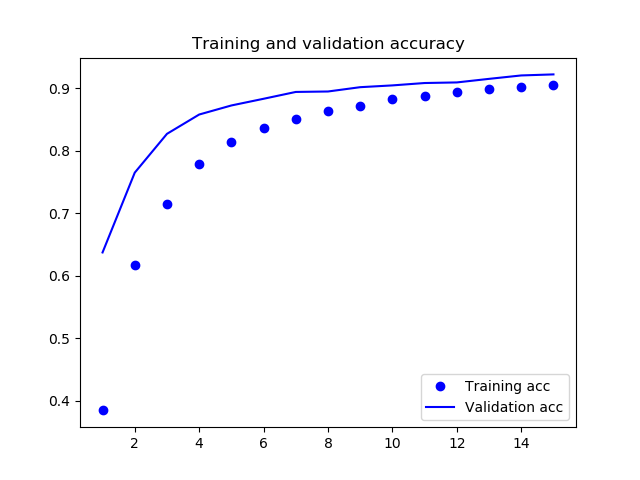

<IPython.core.display.Javascript object>


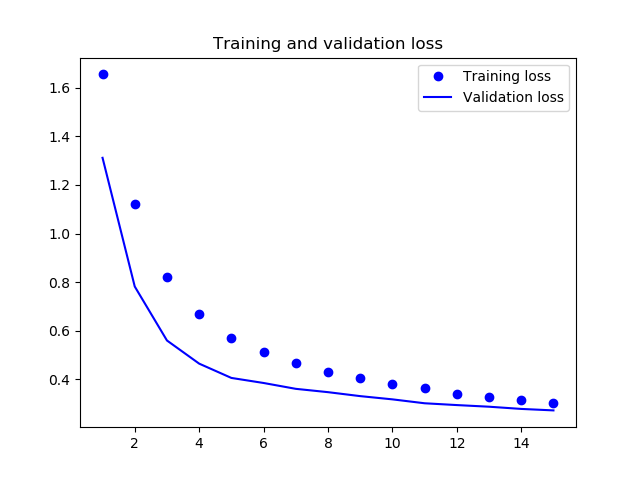

In [20]:
import matplotlib.pyplot as plt
%matplotlib notebook

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can see that the loss and accuracy of the validation set cenverges to that of the trainning set - as it should.

Now we'll look at the model performance for each class (and also at the f1 scores):

In [21]:
from sklearn.metrics import classification_report

y_pred = []
y_true = []
test_pred = model.predict(X_test)

for pred_arr in test_pred:
    pred = np.argmax(pred_arr)
    y_pred.append(pred)
    
for true_arr in y_test:
    true = np.argmax(true_arr)
    y_true.append(true)
    
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1230
           1       0.86      0.89      0.87      1223
           2       0.91      0.88      0.89       783
           3       0.87      0.90      0.88      1270
           4       0.91      0.88      0.89      1235
           5       0.97      0.96      0.96      1267

   micro avg       0.92      0.92      0.92      7008
   macro avg       0.92      0.91      0.92      7008
weighted avg       0.92      0.92      0.92      7008



We can see that the model performs well for all labels 

## Examples

Here are some examples, we can see that the model classifies correctly

In [27]:
code = ["model = KNeighborsClassifier(n_neighbors=3)\n model.fit(x, y)"]
seq = tokenizer.texts_to_sequences(code)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['Load', 'Prep', 'Train', 'Eval', 'Explore', 'Import']
print(pred, labels[np.argmax(pred)])

[[1.3238081e-04 8.3957275e-04 9.9528080e-01 3.6032845e-03 6.2147315e-05
  8.1716513e-05]] Train


In [28]:
code = ["import library\nimport otherlibrary"]
seq = tokenizer.texts_to_sequences(code)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
print(pred, labels[np.argmax(pred)])

[[3.5154476e-04 6.3638628e-04 1.8887708e-04 5.6862072e-03 6.4348237e-04
  9.9249351e-01]] Import


In [29]:
code = ["df.shape\ndf.head()"]
seq = tokenizer.texts_to_sequences(code)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
print(pred, labels[np.argmax(pred)])

[[3.7015238e-04 1.3514721e-03 2.9937828e-05 2.6362494e-04 9.9795723e-01
  2.7600832e-05]] Explore


In [30]:
code = ["accr = model.evaluate(X_test,y_test) print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))"]
seq = tokenizer.texts_to_sequences(code)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
print(pred, labels[np.argmax(pred)])

[[3.9117987e-04 3.6104121e-03 6.0409768e-03 9.8806596e-01 9.3184196e-04
  9.5966528e-04]] Eval


You can try yourself by enetering a cells code:

In [ ]:
code = ["INSERT CODE HERE"]
seq = tokenizer.texts_to_sequences(code)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
print(pred, labels[np.argmax(pred)])

Now if we want to tag all of our cells using the trained model:

In [ ]:
def tag_existing_cells(cells_file_path):
    df = pd.read_csv(cells_file_path, delimiter='\t')
    row_count = df.shape[0]
    labels = ['Load', 'Prep', 'Train', 'Eval', 'Explore', 'Import']
    outputs = pd.Series([]) # to contain output labels
    
    print("Generating labels...")
    for index, row in enumerate(df.iterrows()):
        if index % (row_count//100) == 0:
            print(str(1+(100*index//row_count)) + "%")
        source = df.at[index, "Source"]
        code = [source]
        
        try:
            seq = tokenizer.texts_to_sequences(code)
            padded = pad_sequences(seq, maxlen=max_len)
            pred = model.predict(padded)
            lbl = labels[np.argmax(pred)]
        except:
            lbl = ""
        outputs[index] = lbl
        
    print("Adding labels to dataframe...")
    df['Label'] = outputs.values
    print("Exporting to file...")
    df.to_csv(cells_file_path, sep = '\t')
    print("DONE!")

Our cells file is in a rar file, extract first. <br> To tag your own cells, simply change the path (the file should have a "Source" column with the cells' code and shouldn't have a "Label" column, if it does- delete it).

In [ ]:
tag_existing_cells("../Data/cells.tsv")